In [ ]:
! pip install python-Levenshtein

In [ ]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np


# Прочтение таблиц

In [ ]:
data = pd.read_csv("/content/Matchstick_Man.tsv")
data.head()

,Rank\tRead.count\tRead.proportion\tCDR3.nucleotide.sequence\tCDR3.amino.acid.sequence\tbestVGene\tbestJGene
0,0\t7000\t0.00729773290714573\tTGCGCCAGCAGCCCCC...
1,1\t3966\t0.00413468695853428\tTGTGCCAGCAGTTCCC...
2,2\t3221\t0.00335799967055949\tTGCAGTGCTTCTCTTG...
3,3\t2412\t0.00251459025314793\tTGTGCCAGCAGTTACG...
4,4\t2292\t0.002389486260454\tTGTGCCAGCAGTTGGGGA...


In [ ]:
df = pd.DataFrame(data)
df.columns = ['data']
df['CDR3.amino.acid.sequence'] = df['data'].str.split('\t').str[4]
df['Read.proportion'] = df['data'].str.split('\t').str[2]
df['Read.proportion'] = pd.to_numeric(df['Read.proportion'])
df['Read.count'] = df['data'].str.split('\t').str[1]
df['bestVGene'] = df['data'].str.split('\t').str[5]
df['bestJGene'] = df['data'].str.split('\t').str[6]
del df['data']
df

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSPQFTGSYEQYF,0.007298,7000,TRBV4-3,TRBJ2-7
1,CASSSPIAGQSSYEQYF,0.004135,3966,TRBV28,TRBJ2-7
2,CSASLASGTGELFF,0.003358,3221,TRBV20-1,TRBJ2-2
3,CASSYGQGNQPQHF,0.002515,2412,TRBV6-5,TRBJ1-5
4,CASSWGQGVNEQYF,0.002389,2292,TRBV28,TRBJ2-7
...,...,...,...,...,...
575871,FSSSPDHSLLGGEAFF,0.000001,1,TRBV7-8,TRBJ1-1
575872,FSSSPLALGNNEAFF,0.000001,1,TRBV12-3,TRBJ1-1
575873,FSSSYRGVGNEKLFF,0.000001,1,TRBV6-5,TRBJ1-4
575874,FSSSRCQSATTEAFF,0.000001,1,TRBV19,TRBJ1-1


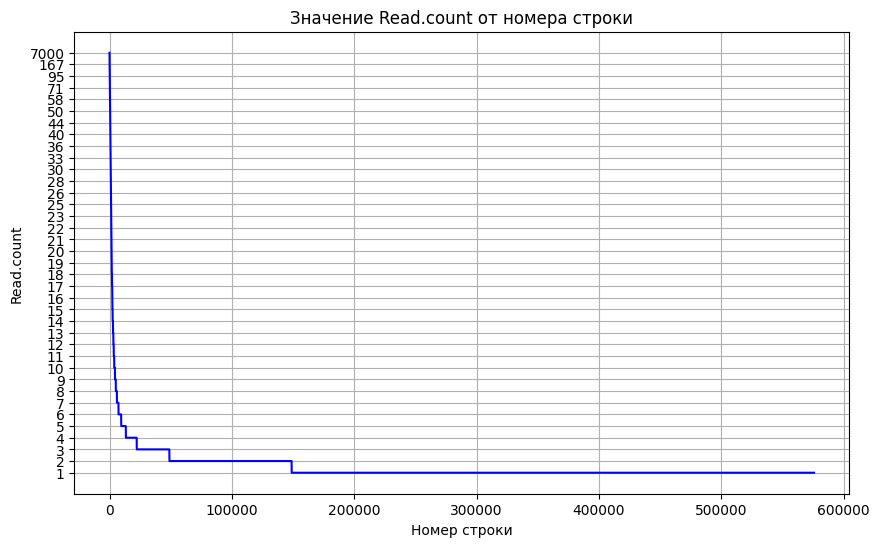

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[::100], df['Read.count'][::100], linestyle='-', color='b')
plt.xlabel('Номер строки')
plt.ylabel('Read.count')
plt.title('Значение Read.count от номера строки')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
index_30 = df[df['Read.count'] == '40'].index
print(index_30)

Index([682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695,
       696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709,
       710, 711, 712, 713, 714],
      dtype='int64')


In [ ]:
database = pd.read_excel("/content/vdjdb_slim.xlsx")

In [ ]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [ ]:
data_claster = df[:682]
data_claster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSPQFTGSYEQYF,0.007298,7000,TRBV4-3,TRBJ2-7
1,CASSSPIAGQSSYEQYF,0.004135,3966,TRBV28,TRBJ2-7
2,CSASLASGTGELFF,0.003358,3221,TRBV20-1,TRBJ2-2
3,CASSYGQGNQPQHF,0.002515,2412,TRBV6-5,TRBJ1-5
4,CASSWGQGVNEQYF,0.002389,2292,TRBV28,TRBJ2-7
...,...,...,...,...,...
677,CASSDGPAANEQFF,0.000043,41,TRBV6-4,TRBJ2-1
678,CASSDFVLTQFF,0.000043,41,TRBV6-1,TRBJ2-1
679,CASSLHGSGGEQYF,0.000043,41,TRBV12-4,TRBJ2-7
680,CASSLGGFSYEQYF,0.000043,41,TRBV12-4,TRBJ2-7


# Функция кластеризации

In [ ]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [ ]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
0,CASSPQFTGSYEQYF,0.007298,7000,TRBV4-3,TRBJ2-7,1
1,CASSSPIAGQSSYEQYF,0.004135,3966,TRBV28,TRBJ2-7,2
2,CSASLASGTGELFF,0.003358,3221,TRBV20-1,TRBJ2-2,3
3,CASSYGQGNQPQHF,0.002515,2412,TRBV6-5,TRBJ1-5,4
4,CASSWGQGVNEQYF,0.002389,2292,TRBV28,TRBJ2-7,5
...,...,...,...,...,...,...
677,CASSDGPAANEQFF,0.000043,41,TRBV6-4,TRBJ2-1,662
678,CASSDFVLTQFF,0.000043,41,TRBV6-1,TRBJ2-1,663
679,CASSLHGSGGEQYF,0.000043,41,TRBV12-4,TRBJ2-7,664
680,CASSLGGFSYEQYF,0.000043,41,TRBV12-4,TRBJ2-7,665


# Подсчёт Total Read Proportion

In [ ]:
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
cluster_counts = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      cluster_counts[i + 1] = cluster_counts.get(i + 1, 0) + 1
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [ ]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
127,128,0.000287,3
355,356,0.000172,3
413,414,0.000107,2
204,205,0.000182,2
35,36,0.000444,2
...,...,...,...
227,228,0.000090,1
228,229,0.000090,1
229,230,0.000089,1
230,231,0.000089,1


# Сортировка по Total Read Proportion

In [ ]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted

,Cluster,Total Read Proportion,Sequence Count
0,1,0.007477,2
3,4,0.003403,2
35,36,0.000444,2
127,128,0.000287,3
204,205,0.000182,2
197,198,0.000172,2
355,356,0.000172,3
145,146,0.000171,2
198,199,0.000158,2
263,264,0.000156,2


# Выбор кластера

In [ ]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,23,CASSLEGQASSYEQYF,0.000520,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,LMP2A
1,23,CASSLEGQASSYEQYF,0.000520,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,BMLF1
2,74,CASSQGAGELFF,0.000222,TRBV12-4,TRBJ2-2,"TRBV12-4*01,TRBV4-2*01",TRBJ2-2*01,MHCI,HomoSapiens,InfluenzaA,M
3,74,CASSQGAGELFF,0.000222,TRBV12-4,TRBJ2-2,TRBV12-4*01,TRBJ2-2*01,MHCI,HomoSapiens,CMV,IE1
4,92,CASSPTGNTEAFF,0.000189,TRBV9,TRBJ1-1,TRBV25-1*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
5,128,CASSSTDTQYF,0.000137,TRBV12-4,TRBJ2-3,TRBV9*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,MLANA
6,128,CASSSTDTQYF,0.000137,TRBV12-4,TRBJ2-3,"TRBV5-6*01,TRBV12-3*01,TRBV10-1*01",TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1
7,133,CASSWTSGYNEQFF,0.000132,TRBV11-2,TRBJ2-1,"TRBV12-4*01,TRBV5-1*01",TRBJ2-1*01,MHCI,HomoSapiens,CMV,IE1
8,142,CASSLGGGNTEAFF,0.000127,TRBV5-1,TRBJ1-1,TRBV7-6*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
9,128,CASSSTDTQYF,0.000105,TRBV12-4,TRBJ2-3,TRBV9*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,MLANA


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,23,CASSLEGQASSYEQYF,0.000520,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,LMP2A
1,23,CASSLEGQASSYEQYF,0.000520,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,BMLF1
2,74,CASSQGAGELFF,0.000222,TRBV12-4,TRBJ2-2,"TRBV12-4*01,TRBV4-2*01",TRBJ2-2*01,MHCI,HomoSapiens,InfluenzaA,M
3,74,CASSQGAGELFF,0.000222,TRBV12-4,TRBJ2-2,TRBV12-4*01,TRBJ2-2*01,MHCI,HomoSapiens,CMV,IE1
13,198,CASSLGGTYEQYF,0.000073,TRBV7-8,TRBJ2-7,TRBV7-8*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,BMLF1
27,518,CSVEGDSYEQYF,0.000050,TRBV29-1,TRBJ2-7,TRBV29-1*01,TRBJ2-7*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
29,598,CSARSGVGNTIYF,0.000045,TRBV20-1,TRBJ1-3,TRBV20-1*01,TRBJ1-3*01,MHCI,HomoSapiens,EBV,BMLF1


In [ ]:
full_vj['Cluster'].value_counts()

,count
Cluster,
23,2
74,2
198,1
518,1
598,1


# Обработка для одного выбранного кластера

In [ ]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 23]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
23,CASSLEGQASSYEQYF,0.00052,499,TRBV5-1,TRBJ2-7,23


In [ ]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,23,CASSLEGQASSYEQYF,0.00052,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,LMP2A
1,23,CASSLEGQASSYEQYF,0.00052,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,EBV,BMLF1


In [ ]:
full['antigen.gene'].value_counts()

,count
antigen.gene,
LMP2A,1
BMLF1,1
